In [ ]:
!pip instal tensorflow

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from google.colab import files
uploaded = files.upload()

Saving train_data.csv to train_data (1).csv


In [ ]:

def prepare_data(df, target_column='was_alarm_event', test_size=0.2, random_state=42):

    X = df.drop(columns=[target_column])
    y = df[target_column]

    class_counts = y.value_counts()
    print(f"\nРозподіл класів:")
    for cls, count in class_counts.items():
        print(f"Клас {cls}: {count} зразків ({count/len(y):.2%})")

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    scaler = StandardScaler()

    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

    if len(numeric_cols) > 0:
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test, scaler


In [ ]:

def create_balanced_model(input_shape, hidden_layers=[256, 128, 64], learning_rate=0.001):
    model = Sequential()

    # Вхідний шар
    model.add(Dense(hidden_layers[0], activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4)) 

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.F1Score(name='f1')
        ]
    )

    return model


In [ ]:

def train_balanced_model(X_train, y_train, X_val, y_val, epochs=100, batch_size=64, verbose=1):
    class_weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train
    )
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    print(f"\nВаги класів: {class_weight_dict}")

    model = create_balanced_model(X_train.shape[1])

    # Колбеки
    callbacks = [
        EarlyStopping(
            monitor='val_f1',
            patience=15,
            restore_best_weights=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_f1',
            factor=0.5,
            patience=7,
            min_lr=0.00001,
            mode='max'
        ),
        ModelCheckpoint(
            'best_model.h5',
            monitor='val_f1',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]

    # training the model з балансом класів
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight_dict,
        verbose=verbose
    )

    return model, history


In [ ]:

def find_optimal_threshold(model, X_val, y_val):
    y_pred_prob = model.predict(X_val).ravel()

    thresholds = np.arange(0.1, 0.9, 0.05)
    f1_scores = []

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)

    best_threshold_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_threshold_idx]
    best_f1 = f1_scores[best_threshold_idx]

    print(f"\nОптимальний поріг: {best_threshold:.2f} (F1-score: {best_f1:.4f})")

    # F1-score
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Оптимальний поріг: {best_threshold:.2f}')
    plt.title('F1-score для різних порогів класифікації')
    plt.xlabel('Поріг')
    plt.ylabel('F1-score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_threshold


In [ ]:

def evaluate_binary_classifier(model, X_test, y_test, threshold=0.5):
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob >= threshold).astype(int)

    print("\nЗвіт класифікації:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Немає тривоги', 'Тривога'],
                yticklabels=['Немає тривоги', 'Тривога'])
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.tight_layout()
    plt.show()

    # ROC крива
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC крива (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Крива')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='green', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Крива')
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    # acc під час навчання модельки 
    plt.figure(figsize=(15, 8))

    # accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Точність моделі')
    plt.ylabel('Точність')
    plt.xlabel('Епоха')
    plt.legend(['Навчальна', 'Валідаційна'], loc='lower right')
    plt.grid(True)

    # втрати
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Функція втрат')
    plt.ylabel('Втрати')
    plt.xlabel('Епоха')
    plt.legend(['Навчальна', 'Валідаційна'], loc='upper right')
    plt.grid(True)

    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('AUC')
    plt.ylabel('AUC')
    plt.xlabel('Епоха')
    plt.legend(['Навчальна', 'Валідаційна'], loc='lower right')
    plt.grid(True)

    # F1
    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('F1-score')
    plt.ylabel('F1-score')
    plt.xlabel('Епоха')
    plt.legend(['Навчальна', 'Валідаційна'], loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [51]:
!ls

 sample_data  'train_data (1).csv'   train_data.csv



Розподіл класів:
Клас 0: 502852 зразків (71.65%)
Клас 1: 198995 зразків (28.35%)

Ваги класів: {0: np.float64(0.6978666653408936), 1: np.float64(1.763477097414508)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8767/8774 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6234 - auc: 0.6779 - f1: 0.4430 - loss: 0.6563 - precision: 0.4009 - recall: 0.6471
Epoch 1: val_f1 improved from -inf to 0.44180, saving model to best_model.h5


8774/8774 ━━━━━━━━━━━━━━━━━━━━ 55s 6ms/step - accuracy: 0.6234 - auc: 0.6780 - f1: 0.4430 - loss: 0.6562 - precision: 0.4010 - recall: 0.6471 - val_accuracy: 0.6776 - val_auc: 0.7741 - val_f1: 0.4418 - val_loss: 0.5749 - val_precision: 0.4585 - val_recall: 0.7572 - learning_rate: 0.0010
Epoch 2/10
8770/8774 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6769 - auc: 0.7601 - f1: 0.4418 - loss: 0.5821 - precision: 0.4563 - recall: 0.7278
Epoch 2: val_f1 did not improve from 0.44180
8774/8774 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.6769 - auc: 0.7601 - f1: 0.4418 - loss: 0.5821 - precision: 0.4563 - recall: 0.7278 - val_accuracy: 0.6895 - val_auc: 0.7924 - val_f1: 0.4418 - val_loss: 0.5553 - val_precision: 0.4712 - val_recall: 0.7770 - learning_rate: 0.0010
Epoch 3/10
8767/8774 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6867 - auc: 0.7728 - f1: 0.4411 - loss: 0.5691 - precision: 0.4661 - recall: 0.7375
Epoch 3: val_f1 did not improve from 0.44180
8774/8774 ━━━━━━━━━━━━━━━━━━━━

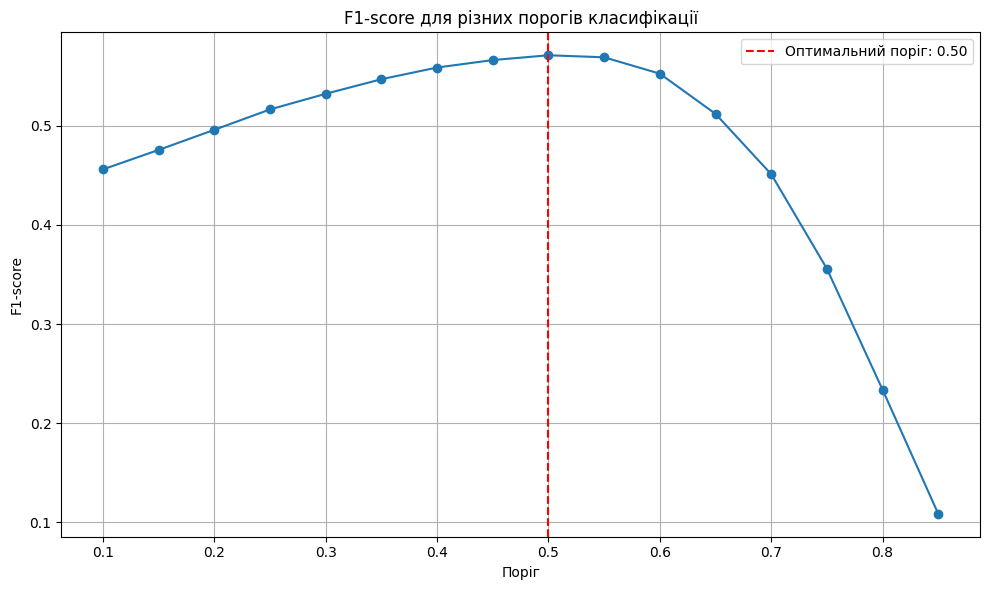

2194/2194 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Звіт класифікації:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74     50286
           1       0.46      0.76      0.57     19899

    accuracy                           0.68     70185
   macro avg       0.66      0.70      0.66     70185
weighted avg       0.75      0.68      0.69     70185



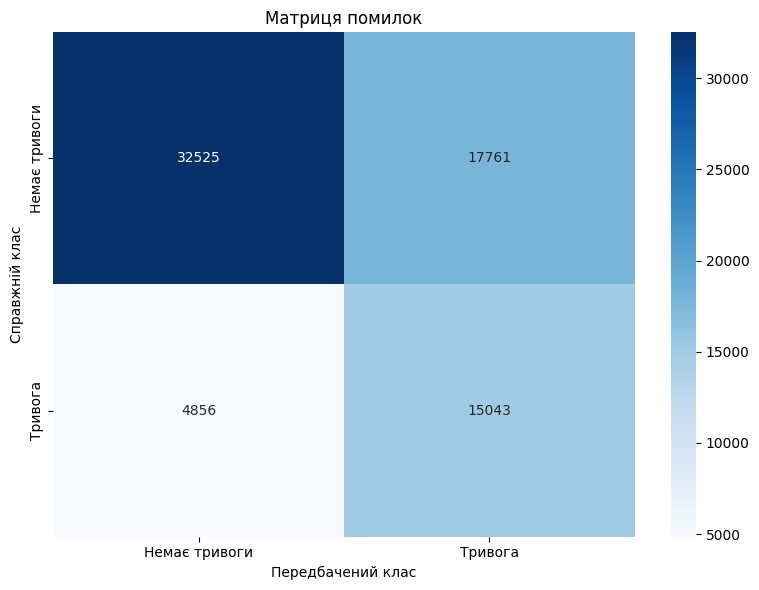

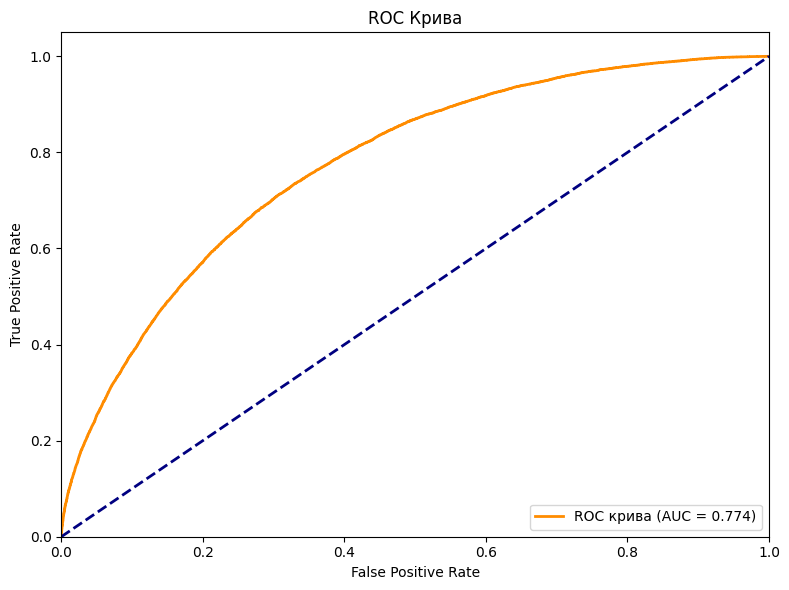

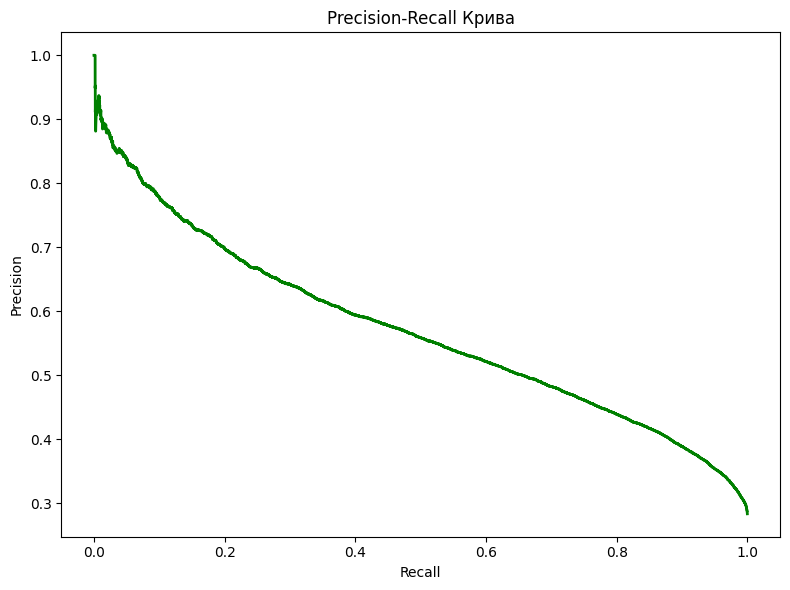

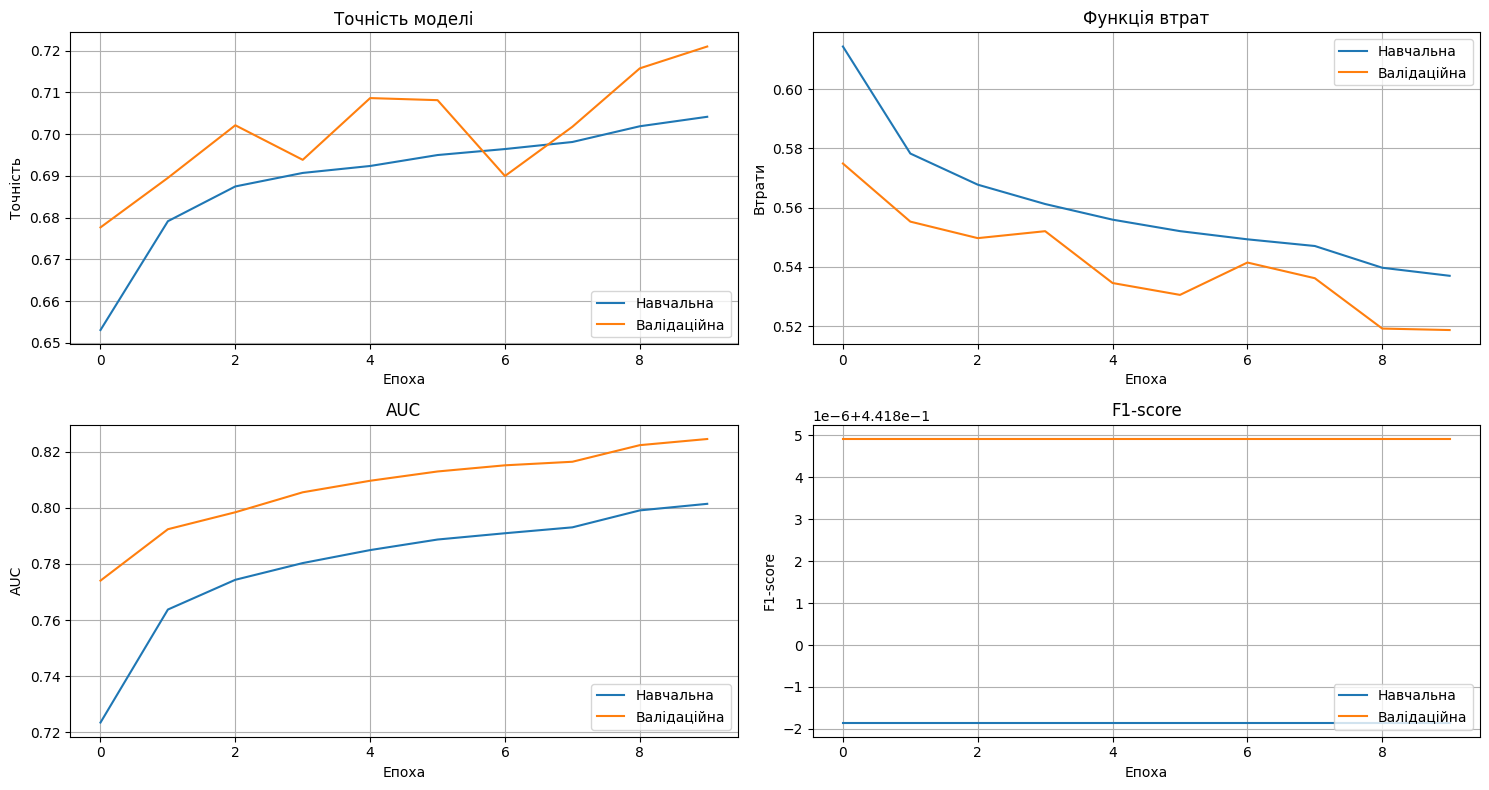

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Передбачення для нового вхідного вектора:
Ймовірність тривоги: 0.8131
Поріг класифікації: 0.5000
Передбачений клас: 1 ('Тривога' якщо 1, 'Немає тривоги' якщо 0)


<ipython-input-53-f580fcbdfe9f>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data[numeric_cols] = scaler.transform(new_data[numeric_cols])


In [ ]:

if __name__ == "__main__":

    df = pd.read_csv('train_data.csv', sep=';')
    df = df.drop(columns=['Unnamed: 0'], axis='1')

    X_train, X_val, y_train, y_val, scaler = prepare_data(df, target_column='was_alarm_event')

    X_val, X_test, y_val, y_test = train_test_split(
        X_val, y_val, test_size=0.5, random_state=42, stratify=y_val
    )

    model, history = train_balanced_model(X_train, y_train, X_val, y_val, epochs=10)

    optimal_threshold = find_optimal_threshold(model, X_val, y_val)

    evaluate_binary_classifier(model, X_test, y_test, threshold=optimal_threshold)

    plot_training_history(history)

    new_data = X_test.iloc[0:1]

    numeric_cols = new_data.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        new_data[numeric_cols] = scaler.transform(new_data[numeric_cols])

    prediction_prob = model.predict(new_data)[0][0]
    prediction_class = 1 if prediction_prob >= optimal_threshold else 0

    print(f"\nПередбачення для нового вхідного вектора:")
    print(f"Ймовірність тривоги: {prediction_prob:.4f}")
    print(f"Поріг класифікації: {optimal_threshold:.4f}")
    print(f"Передбачений клас: {prediction_class} ('Тривога' якщо 1, 'Немає тривоги' якщо 0)")